In [91]:
%matplotlib widget


In [93]:
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt
import numpy as np, pandas as pd




In [95]:
df = pd.read_csv("shots_clean1.csv")


In [97]:
home_name, away_name = "city", "spurs"
TOP_TEAM = home_name

In [99]:
df["team"] = df["team"].astype(str).str.strip()
df["team_name"] = np.where(df["team"].str.lower().eq("home"), home_name, away_name)

df["norm_x"] = pd.to_numeric(df["x"], errors="coerce").clip(0, 100)
df["norm_y"] = pd.to_numeric(df["y"], errors="coerce").clip(0, 100)

mask_flip = df["team_name"] != TOP_TEAM
df.loc[mask_flip, ["norm_x","norm_y"]] = 100 - df.loc[mask_flip, ["norm_x","norm_y"]].values

if "size" not in df.columns:
    df["size"] = (df["xg"].fillna(0).astype(float) * 800).clip(30, 250)

if "is_goal" not in df.columns:
    df["is_goal"] = df.get("outcome", "").astype(str).str.contains("goal", case=False, na=False)

top_df = df[df["team_name"] == TOP_TEAM].reset_index(drop=True)
bot_df = df[df["team_name"] != TOP_TEAM].reset_index(drop=True)
top_name = TOP_TEAM
bot_name = away_name if TOP_TEAM == home_name else home_name


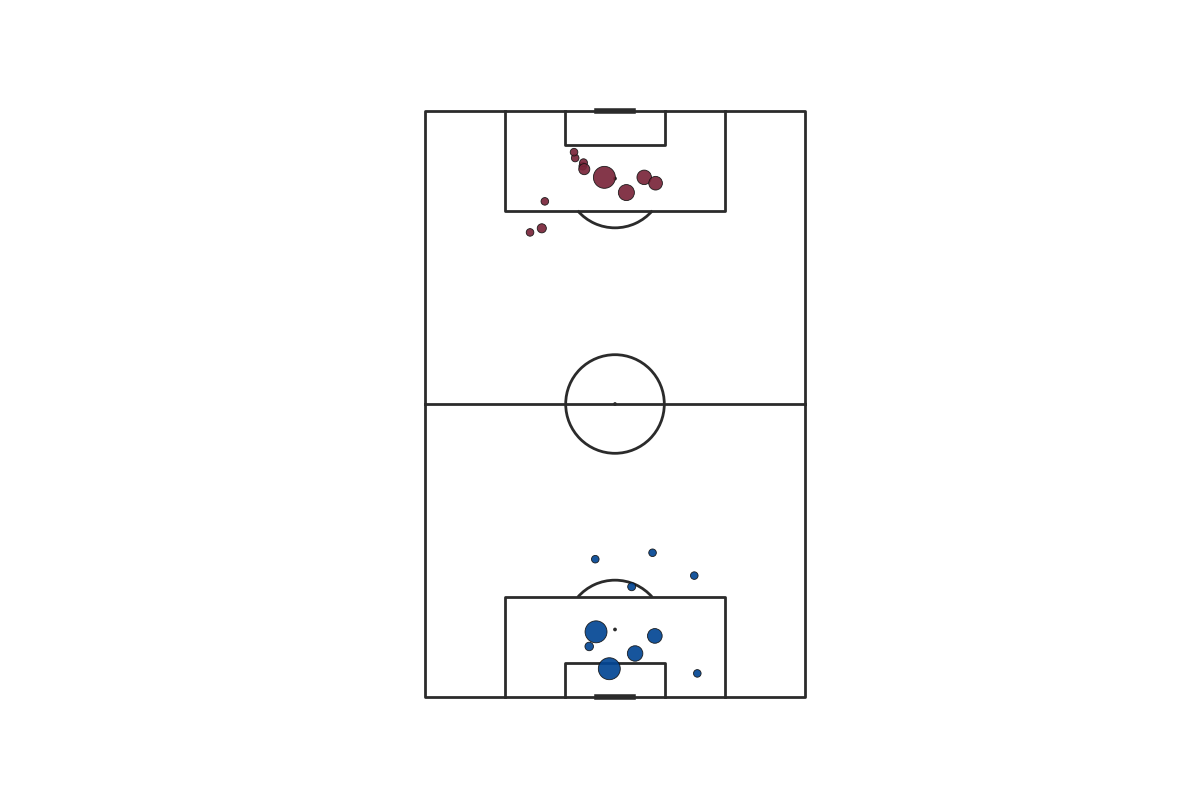

In [103]:
pitch = VerticalPitch(pitch_type="opta", half=False, pitch_color="white", line_color="#2b2b2b")
fig, ax = pitch.draw(figsize=(12, 8), constrained_layout=True, tight_layout=False)

def team_color(name):
    return {"city": "#034694", "spurs": "#7A263A"}.get(name, "#1f77b4")
color_top = team_color(top_name)
color_bot = team_color(bot_name)

art_top = pitch.scatter(top_df["norm_x"], top_df["norm_y"], s=top_df["size"],
                        color=color_top, edgecolors="#111", linewidth=0.6, alpha=0.92,
                        label=f"{top_name} shots: {len(top_df)}",
                        ax=ax, zorder=10, picker=True, pickradius=8)
art_top.df = top_df; art_top.team = top_name

art_bot = pitch.scatter(bot_df["norm_x"], bot_df["norm_y"], s=bot_df["size"],
                        color=color_bot, edgecolors="#111", linewidth=0.6, alpha=0.92,
                        label=f"{bot_name} shots: {len(bot_df)}",
                        ax=ax, zorder=10, picker=True, pickradius=8)
art_bot.df = bot_df; art_bot.team = bot_name






In [105]:
for sub in (top_df[top_df["is_goal"]], bot_df[bot_df["is_goal"]]):
    if not sub.empty:
        pitch.scatter(sub["norm_x"], sub["norm_y"], s=sub["size"]*1.25,
                      facecolors="none", edgecolors="gold", linewidth=2, ax=ax, zorder=15)

In [107]:

ax.set_title(f"{top_name} (top) vs {bot_name} (bottom) — size ~ xG, yellow ring = Goal",
             color="black", pad=10)
leg = ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False)
for t in leg.get_texts(): t.set_color("black")

In [109]:
annot = ax.annotate("", xy=(0,0), xytext=(10,12), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="black", ec="white", alpha=0.85),
                    color="white", fontsize=9, visible=False, zorder=30)

# ماركر تمييز للنقطة تحت الماوس
hover_marker = pitch.scatter([np.nan], [np.nan], s=[150],
                             facecolors="none", edgecolors="black",
                             linewidth=1.5, ax=ax, zorder=25)

off_top = art_top.get_offsets()
off_bot = art_bot.get_offsets()



In [111]:
def build_text(artist, idx):
    row = artist.df.iloc[idx]
    minute = row.get("minute_display") or row.get("minute") or ""
    player = row.get("player") or ""
    xg_val = float(row.get("xg") or 0)
    outcome = row.get("outcome") or ""
    return f"{artist.team}\n{player}\nmin: {minute}\nxG: {xg_val:.2f}\n{outcome}"


In [114]:
def set_annot(artist, idx):
    # مكان الأنو و نصه
    offsets = artist.get_offsets()
    x, y = offsets[idx]
    annot.xy = (x, y)
    annot.set_text(build_text(artist, idx))
    annot.set_visible(True)
    # حرّك حلقة التمييز
    hover_marker.set_offsets([(x, y)])
    try:
        # كبّر الحلقة حسب حجم النقطة الأصلية إن أمكن
        size = artist.get_sizes()[idx] if len(artist.get_sizes()) else 150
        hover_marker.set_sizes([size * 1.2])
    except Exception:
        pass
    fig.canvas.draw_idle()


In [116]:
def nearest_point(event):
    """ يرجّع (artist, idx, dist) لأقرب نقطة؛ dist بوحدة الداتا (0..100). """
    if event.inaxes != ax or event.xdata is None or event.ydata is None:
        return None, None, None
    x, y = event.xdata, event.ydata
    d_top = np.hypot(off_top[:,0]-x, off_top[:,1]-y) if len(off_top) else np.array([np.inf])
    d_bot = np.hypot(off_bot[:,0]-x, off_bot[:,1]-y) if len(off_bot) else np.array([np.inf])
    i_top, i_bot = int(d_top.argmin()), int(d_bot.argmin())
    if d_top.min() <= d_bot.min():
        return art_top, i_top, d_top.min()
    else:
        return art_bot, i_bot, d_bot.min()

# Hover: أظهر الأنو لما الماوس يقرب لمسافة threshold (بوحدة الداتا)
THRESH = 2.5  # زوّدها لو مش بتلقط بسهولة
def on_move(event):
    artist, idx, dist = nearest_point(event)
    if artist is None:
        if annot.get_visible():
            annot.set_visible(False)
            hover_marker.set_offsets([(np.nan, np.nan)])
            fig.canvas.draw_idle()
        return
    if dist is not None and dist < THRESH:
        set_annot(artist, idx)
    else:
        if annot.get_visible():
            annot.set_visible(False)
            hover_marker.set_offsets([(np.nan, np.nan)])
            fig.canvas.draw_idle()



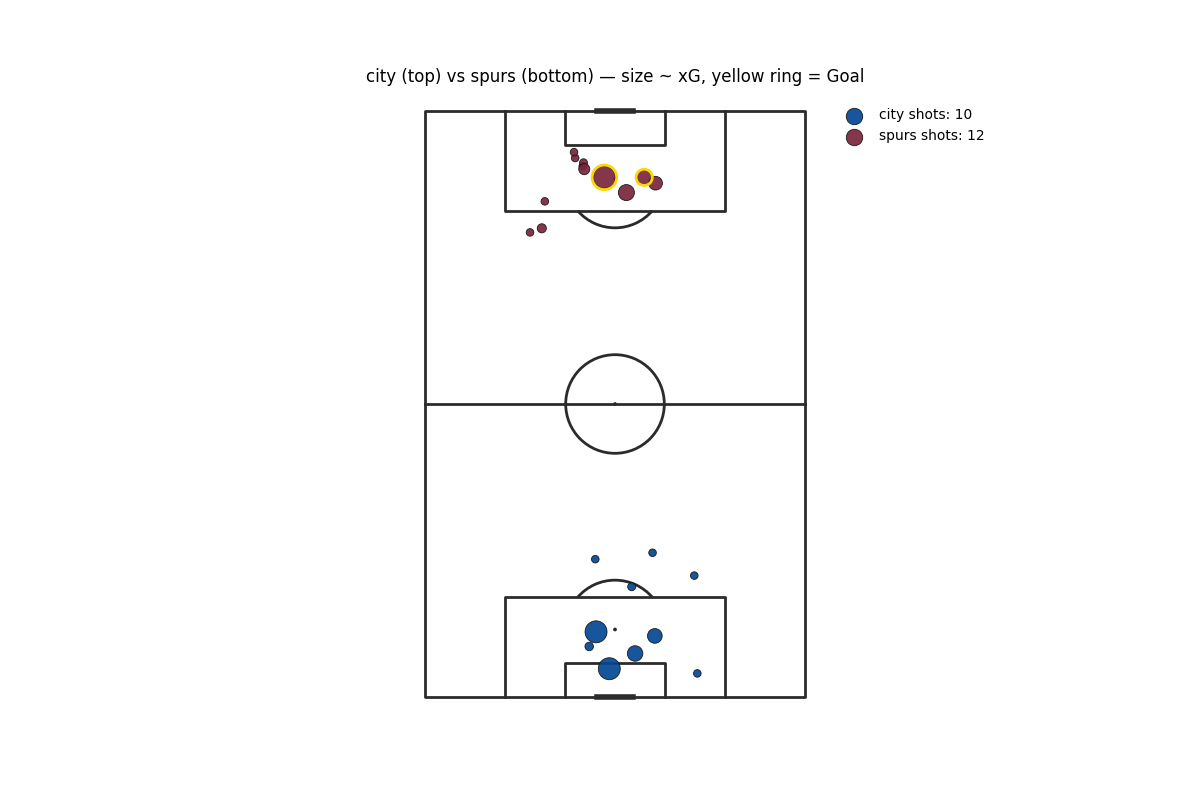

In [118]:
def on_pick(event):
    # Fallback بالـ click دايمًا يشتغل
    artist = event.artist
    if artist not in (art_top, art_bot): 
        return
    idx = int(event.ind[0]) if getattr(event, "ind", []) else None
    if idx is None: 
        return
    set_annot(artist, idx)

# اطفي أي وضع Pan/Zoom نشط
try:
    ax.figure.canvas.toolbar.mode = ''
except Exception:
    pass

cid1 = fig.canvas.mpl_connect("motion_notify_event", on_move)
cid2 = fig.canvas.mpl_connect("pick_event", on_pick)

plt.show()


In [61]:
print(df.columns)


Index(['minute_display', 'team', 'player', 'pos', 'no', 'xg', 'x', 'y',
       'outcome', 'shotType', 'goalType', 'team_name', 'norm_x', 'norm_y',
       'size', 'is_goal'],
      dtype='object')
